In [1]:
import boto3
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import re  # Import regex module
import json  # Import JSON module
from sagemaker import Session
import numpy as np


# Initialize a SageMaker session
sagemaker_session = Session()

# Define AWS IAM role
role = "arn:aws:iam::016114370410:role/tf-binding-sites"

# Base S3 prefix where output files are stored
base_prefix = "inference/output/"

# Local directory where JSONL files will be stored, organized by TF-SRR_id
local_dir = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/jsonl_output"

# List of experiment prefixes to download from S3, ordered by TF
experiment_prefixes = [

    # ASCL1
    "ASCL1-SRR12455445-2024-12-11-13-38-40",
    "ASCL1-SRR12455442-2024-12-11-13-10-02",
    "ASCL1-SRR12455440-2024-12-11-13-02-22",
    "ASCL1-SRR12455441-2024-12-11-12-52-28",
    "ASCL1-SRR12455439-2024-12-11-12-00-20",
    "ASCL1-SRR12455436-2024-12-11-11-36-21",
    "ASCL1-SRR12455437-2024-12-11-11-15-32",
    "ASCL1-SRR12455434-2024-12-11-10-51-41",
    "ASCL1-SRR12455435-2024-12-11-10-18-36",
    "ASCL1-SRR12455435-2024-12-11-10-18-36",
    "ASCL1-SRR12455433-2024-12-11-10-08-40",
    "ASCL1-SRR12455432-2024-12-11-10-04-22",
    # AR
    # "AR-SRR12455434-2024-11-18-08-59-26",
    # "AR-SRR12455435-2024-11-18-08-59-26",
    # "AR-SRR12455433-2024-11-17-13-29-30",
    # "AR-SRR12455432-2024-11-17-13-29-08",
    # "AR-SRR12455430-2024-11-17-12-23-14",
    # "AR-SRR12455431-2024-11-17-12-22-53",
    # "AR-SRR12455445-2024-11-17-10-53-45",
    # "AR-SRR12455444-2024-11-17-10-52-37",
    # "AR-SRR12455443-2024-11-17-09-51-14",
    # "AR-SRR12455442-2024-11-17-09-50-31",
    # "AR-SRR12455440-2024-11-17-08-43-17",
    # "AR-SRR12455441-2024-11-17-08-42-25",
    # "AR-SRR12455439-2024-11-15-16-48-56",
    # "AR-SRR12455438-2024-11-15-16-45-49",
    # "AR-SRR12455436-2024-11-15-11-12-08",
    # "AR-SRR12455437-2024-11-15-10-26-20",

    # # FOXA1
    # "FOXA1-SRR12455434-2024-11-18-10-19-29",
    # "FOXA1-SRR12455435-2024-11-18-09-52-43",
    # "FOXA1-SRR12455433-2024-11-17-14-09-19",
    # "FOXA1-SRR12455432-2024-11-17-14-05-41",
    # "FOXA1-SRR12455431-2024-11-17-13-09-21",
    # "FOXA1-SRR12455430-2024-11-17-12-54-47",
    # "FOXA1-SRR12455444-2024-11-17-11-40-51",
    # "FOXA1-SRR12455445-2024-11-17-11-40-07",
    # "FOXA1-SRR12455442-2024-11-17-10-32-45",
    # "FOXA1-SRR12455443-2024-11-17-10-30-26",
    # "FOXA1-SRR12455440-2024-11-17-09-41-25",
    # "FOXA1-SRR12455441-2024-11-17-09-33-55",
    # "FOXA1-SRR12455439-2024-11-15-17-55-03",
    # "FOXA1-SRR12455438-2024-11-15-17-50-47",
    # "FOXA1-SRR12455436-2024-11-15-12-17-36",
    # "FOXA1-SRR12455437-2024-11-15-11-35-47",

    # NCI-H446
    # "NEUROD1-NCI-H446-SRR12455441-2024-12-04-14-30-41",
    # "NEUROD1-NCI-H446-SRR12455439-2024-12-04-13-26-04",
    # "NEUROD1-NCI-H446-SRR12455436-2024-12-04-13-03-13",
    # "NEUROD1-NCI-H446-SRR12455437-2024-12-04-12-11-43",
    # "NEUROD1-NCI-H446-SRR12455434-2024-12-04-11-39-23",

    # "NEUROD1-NCI-H446-SRR12455432-2024-12-03-17-04-57",
    # "NEUROD1-NCI-H446-SRR12455433-2024-12-03-17-08-24",
    # "NEUROD1-NCI-H446-SRR12455435-2024-12-03-17-16-44",
    # "NEUROD1-NCI-H446-SRR12455434-2024-12-03-17-44-59",
    # "NEUROD1-NCI-H446-SRR12455437-2024-12-03-18-07-42",
    # "NEUROD1-NCI-H446-SRR12455436-2024-12-03-18-24-01",
    # "NEUROD1-NCI-H446-SRR12455439-2024-12-03-18-44-15",
    # "NEUROD1-NCI-H446-SRR12455440-2024-12-03-19-25-13",
    # "NEUROD1-NCI-H446-SRR12455441-2024-12-03-19-26-25",
    # "NEUROD1-NCI-H446-SRR12455442-2024-12-03-19-39-22",
    # "NEUROD1-NCI-H446-SRR12455445-2024-12-03-20-05-40"


    # RB1
    # "RB1-SRR12455445-2024-12-04-18-15-29",
    # "RB1-SRR12455442-2024-12-04-17-45-35",
    # "RB1-SRR12455440-2024-12-04-17-35-04",
    # "RB1-SRR12455441-2024-12-04-17-35-17",
    # "RB1-SRR12455439-2024-12-04-16-52-52",
    # "RB1-SRR12455436-2024-12-04-16-28-55",
    # "RB1-SRR12455432-2024-12-04-14-56-09",
    # "RB1-SRR12455437-2024-12-04-16-07-59",
    # "RB1-SRR12455433-2024-12-04-15-03-36",
    # "RB1-SRR12455434-2024-12-04-15-57-44",
    # "RB1-SRR12455435-2024-12-04-15-23-07"
]

# Initialize the S3 client
s3 = boto3.client('s3')

# Specify your S3 bucket name
bucket_name = "tf-binding-sites"

# Function to download files from an S3 bucket to a specific local directory
def download_from_s3(bucket_name, prefix, local_dir):
    """
    Downloads all files from the specified S3 bucket and prefix to the local directory.
    
    Parameters:
        bucket_name (str): Name of the S3 bucket.
        prefix (str): Prefix path in the S3 bucket.
        local_dir (str): Local directory to save the downloaded files.
    """
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
        print(f'Created directory: {local_dir}')

    # Use paginator to handle large number of objects
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

    for page in pages:
        for obj in page.get('Contents', []):
            key = obj['Key']
            # Skip if it's a folder
            if key.endswith('/'):
                continue
            local_path = os.path.join(local_dir, os.path.basename(key))
            
            # Check if the file already exists to avoid re-downloading
            if os.path.exists(local_path):
                print(f'File {local_path} already exists. Skipping download.')
                continue

            try:
                # Download the file
                s3.download_file(bucket_name, key, local_path)
                print(f'Downloaded {key} to {local_path}')
            except Exception as e:
                print(f'Error downloading {key}: {e}')

# Define the phenotype mapping as a dictionary
phenotype_mapping = {
    # ADPC samples
    "SRR12455436": "ADPC",
    "SRR12455439": "ADPC", 
    "SRR12455440": "ADPC",
    "SRR12455441": "ADPC",
    "SRR12455442": "ADPC",
    "SRR12455445": "ADPC",
    
    # NEPC samples
    "SRR12455430": "NEPC",
    "SRR12455431": "NEPC",
    "SRR12455432": "NEPC",
    "SRR12455433": "NEPC",
    # "SRR12455434": "NEPC",
    "SRR12455435": "NEPC",
    "SRR12455437": "NEPC",
    "SRR12455438": "NEPC",
    "SRR12455443": "NEPC",
    "SRR12455444": "NEPC"
}

# Initialize a list to hold all DataFrames
dataframes = []

# Initialize a list to hold summary records
summary_records = []

# Iterate over each experiment prefix
for exp_prefix in experiment_prefixes:
    print(f'\nProcessing experiment: {exp_prefix}')
    
    # Extract SRR_id and transcription factor from the experiment_prefix
    srr_match = re.search(r'(SRR\d+)', exp_prefix)
    tf_match = re.search(r'^([^-]+)', exp_prefix)
    
    if srr_match:
        srr_id = srr_match.group(1)
    else:
        srr_id = 'Unknown'
        print(f'Warning: SRR ID not found in prefix {exp_prefix}')
        
    if tf_match:
        tf = tf_match.group(1)
    else:
        tf = 'Unknown'
        print(f'Warning: Transcription factor not found in prefix {exp_prefix}')
    
    # Get the phenotype label for the current SRR_id
    phenotype = phenotype_mapping.get(srr_id, 'Unknown')
    if phenotype == 'Unknown':
        print(f'Warning: Phenotype not found for SRR_id {srr_id}')
    
    # Define the subdirectory path based on TF-SRR_id combination
    tf_srr_dir = os.path.join(local_dir, f"{tf}-{srr_id}")
    
    # Check if the tf_srr_dir already exists and has files
    if os.path.exists(tf_srr_dir) and os.listdir(tf_srr_dir):
        print(f'Directory {tf_srr_dir} already exists and is not empty. Skipping download.')
    else:
        # Download files for the current experiment prefix to the TF-SRR specific directory
        download_from_s3(bucket_name, base_prefix + exp_prefix, tf_srr_dir)
    
    # Read downloaded files for this experiment from the TF-SRR specific directory
    json_files = glob.glob(os.path.join(tf_srr_dir, "*.jsonl.gz.out"))
    if not json_files:
        print(f'No JSONL files found for experiment {exp_prefix} in directory {tf_srr_dir}')
        continue  # Skip to the next experiment if no files found
    
    for file in json_files:
        try:
            records = []
            with open(file, 'r') as f:
                for line_num, line in enumerate(f, 1):
                    line = line.strip()
                    if not line:
                        continue  # Skip empty lines
                    try:
                        json_line = json.loads(line)
                        if isinstance(json_line, list):
                            # If the line is a list of dicts, extend the records
                            records.extend(json_line)
                        elif isinstance(json_line, dict):
                            records.append(json_line)
                        else:
                            print(f'Unexpected JSON structure in file {file} at line {line_num}')
                    except json.JSONDecodeError as jde:
                        print(f'JSON decode error in file {file} at line {line_num}: {jde}')
            
            if not records:
                print(f'No valid records found in file {file}')
                continue  # Skip processing if no records found
            
            # Normalize the JSON records to flatten nested structures
            df_part = pd.json_normalize(records)
            
            # Add the SRR_id, Phenotype, and TF columns
            df_part['SRR_id'] = srr_id
            df_part['Phenotype'] = phenotype
            df_part['TF'] = tf
            
            # Perform the prediction operation
            if 'probabilities' in df_part.columns:
                df_part['predicted'] = (df_part['probabilities'] > 0.95).astype(int)
            else:
                print(f"'probabilities' column not found in file {file}. Skipping prediction.")
                continue  # Skip if 'probabilities' column is missing
            
            # Get value counts of the 'predicted' column
            predicted_counts = df_part['predicted'].value_counts().to_dict()
            
            # Prepare a summary record
            summary_record = {
                'SRR_id': srr_id,
                'Phenotype': phenotype,
                'TF': tf,
                'Predicted_0': predicted_counts.get(0, 0),
                'Predicted_1': predicted_counts.get(1, 0)
            }
            
            # Append the summary record to the list
            summary_records.append(summary_record)
            
            # Append the processed dataframe to the list
            dataframes.append(df_part)
            
            print(f'Processed file {file} with SRR_id {srr_id}, records: {len(df_part)}')
        except Exception as e:
            print(f'Error processing file {file}: {e}')

# Create a summary DataFrame from the summary_records list
summary_df = pd.DataFrame(summary_records)

# Display the summary DataFrame
print("\nSummary of Predicted Counts per SRR_id:")
print(summary_df)

# (Optional) Save the summary to a CSV file
summary_csv_path = os.path.join(local_dir, "predicted_summary.csv")
summary_df.to_csv(summary_csv_path, index=False)
print(f'\nSummary saved to {summary_csv_path}')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /data1/home/wjarrard/.config/sagemaker/config.yaml

Processing experiment: ASCL1-SRR12455445-2024-12-11-13-38-40
Directory /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/jsonl_output/ASCL1-SRR12455445 already exists and is not empty. Skipping download.
Processed file /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/jsonl_output/ASCL1-SRR12455445/dataset_106.jsonl.gz.out with SRR_id SRR12455445, records: 691
Processed file /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/jsonl_output/ASCL1-SRR12455445/dataset_10.jsonl.gz.out with SRR_id SRR12455445, records: 308
Processed file /data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/jsonl_output/ASCL1-SRR12455445/dataset_108.js

In [2]:
# print all srrs
summary_df['SRR_id'].unique()


array(['SRR12455445', 'SRR12455442', 'SRR12455440', 'SRR12455441',
       'SRR12455439', 'SRR12455436', 'SRR12455437', 'SRR12455434',
       'SRR12455435', 'SRR12455433', 'SRR12455432'], dtype=object)

In [3]:
# look at total number of peaks between phenotypes for each srr_id
summary_df



,SRR_id,Phenotype,TF,Predicted_0,Predicted_1
0,SRR12455445,ADPC,ASCL1,630,61
1,SRR12455445,ADPC,ASCL1,12,296
2,SRR12455445,ADPC,ASCL1,676,55
3,SRR12455445,ADPC,ASCL1,569,108
4,SRR12455445,ADPC,ASCL1,597,82
...,...,...,...,...,...
1654,SRR12455432,NEPC,ASCL1,11,487
1655,SRR12455432,NEPC,ASCL1,2,399
1656,SRR12455432,NEPC,ASCL1,2,367
1657,SRR12455432,NEPC,ASCL1,22,496


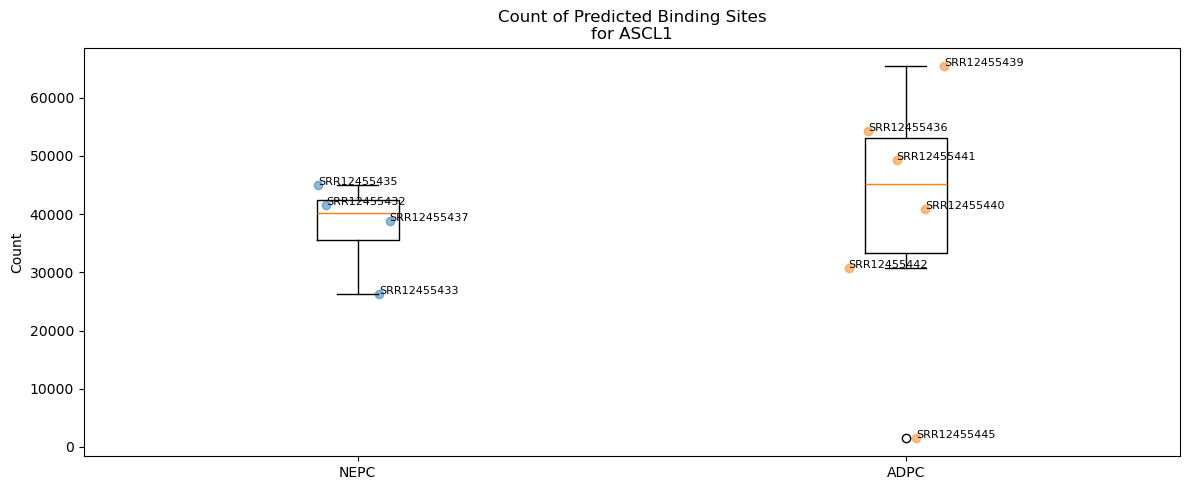

In [4]:
# Group by SRR_id, Phenotype, and TF and calculate mean predicted values
grouped_df = summary_df.groupby(['SRR_id', 'Phenotype', 'TF']).agg({
    'Predicted_0': 'sum',
    'Predicted_1': 'sum'
}).reset_index()

# Calculate total counts and proportions
grouped_df['Total'] = grouped_df['Predicted_0'] + grouped_df['Predicted_1']
grouped_df['Prop_0'] = grouped_df['Predicted_0'] / grouped_df['Total']
grouped_df['Prop_1'] = grouped_df['Predicted_1'] / grouped_df['Total']

grouped_df

# Create plots comparing predicted proportions and counts between phenotypes for each TF
import matplotlib.pyplot as plt

# Get unique TFs
tfs = grouped_df['TF'].unique()

# Create figures for each TF
for tf in tfs:
    # Filter data for current TF
    tf_data = grouped_df[grouped_df['TF'] == tf]
    
    # Get data for each phenotype
    nepc_data = tf_data[tf_data['Phenotype']=='NEPC']
    adpc_data = tf_data[tf_data['Phenotype']=='ADPC']
    
    # Create two subplots - one for proportions, one for counts
    fig, ax2 = plt.subplots(1, 1, figsize=(12, 5))
    
    # # Proportion plot
    # data_prop = [nepc_data['Prop_1'], adpc_data['Prop_1']]
    # bp1 = ax1.boxplot(data_prop, labels=['NEPC', 'ADPC'])
    # ax1.set_title(f'Proportion of Predicted Binding Sites\nfor {tf}')
    # ax1.set_ylabel('Proportion')
    
    # # Add individual points for proportions with labels
    # x = np.random.normal(1, 0.04, size=len(nepc_data['Prop_1']))
    # ax1.scatter(x, nepc_data['Prop_1'], alpha=0.5)
    # for i, txt in enumerate(nepc_data['SRR_id']):
    #     ax1.annotate(txt, (x[i], nepc_data['Prop_1'].iloc[i]), fontsize=8)
        
    # x = np.random.normal(2, 0.04, size=len(adpc_data['Prop_1']))
    # ax1.scatter(x, adpc_data['Prop_1'], alpha=0.5)
    # for i, txt in enumerate(adpc_data['SRR_id']):
    #     ax1.annotate(txt, (x[i], adpc_data['Prop_1'].iloc[i]), fontsize=8)
    
    # Count plot
    data_count = [nepc_data['Predicted_1'], adpc_data['Predicted_1']]
    bp2 = ax2.boxplot(data_count, labels=['NEPC', 'ADPC'])
    ax2.set_title(f'Count of Predicted Binding Sites\nfor {tf}')
    ax2.set_ylabel('Count')
    
    # Add individual points for counts with labels
    x = np.random.normal(1, 0.04, size=len(nepc_data['Predicted_1']))
    ax2.scatter(x, nepc_data['Predicted_1'], alpha=0.5)
    for i, txt in enumerate(nepc_data['SRR_id']):
        ax2.annotate(txt, (x[i], nepc_data['Predicted_1'].iloc[i]), fontsize=8)
        
    x = np.random.normal(2, 0.04, size=len(adpc_data['Predicted_1']))
    ax2.scatter(x, adpc_data['Predicted_1'], alpha=0.5)
    for i, txt in enumerate(adpc_data['SRR_id']):
        ax2.annotate(txt, (x[i], adpc_data['Predicted_1'].iloc[i]), fontsize=8)
    
    plt.tight_layout()
    plt.show()


In [33]:
grouped_df

In [32]:
adpc_data

# Perform Mann-Whitney U test to compare Prop_1 between phenotypes
from scipy import stats

# Extract Prop_1 values for each phenotype
nepc_prop1 = nepc_data['Prop_1']
adpc_prop1 = adpc_data['Prop_1']

# Perform the test
statistic, pvalue = stats.mannwhitneyu(nepc_prop1, adpc_prop1, alternative='two-sided')

print("Mann-Whitney U test results:")
print(f"Statistic: {statistic}")
print(f"P-value: {pvalue}")
